# Lab 5: Spam Detection

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Understand batching for a recurrent neural network, and develop custom Dataset and DataLoaders with collate_fn to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

https://colab.research.google.com/drive/10uwhQm9bGWM3xR_VMRWmpj9kab9hiZ9U#scrollTo=BgE9gcKeMwNe



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [1 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [4]:
# Open and read the file to find examples
spam_example = None
ham_example = None

for line in open('/content/drive/MyDrive/APS360/lab5/SMSSpamCollection'):
    parts = line.strip().split('\t')
    label = parts[0]
    message = parts[1]

    if label == 'spam' and spam_example is None:
        spam_example = message
    elif label == 'ham' and ham_example is None:
        ham_example = message

    if spam_example and ham_example:
        break

print("Example of a spam SMS:")
print(spam_example)
print("\nExample of a non-spam SMS:")
print(ham_example)

print("\nThe label value for a spam message is 'spam'.")
print("The label value for a non-spam message is 'ham'.")

Example of a spam SMS:
Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

Example of a non-spam SMS:
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

The label value for a spam message is 'spam'.
The label value for a non-spam message is 'ham'.


### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [5]:
spam_count = 0
ham_count = 0

for line in open('/content/drive/MyDrive/APS360/lab5/SMSSpamCollection'):
    parts = line.strip().split('\t')
    label = parts[0]

    if label == 'spam':
        spam_count += 1
    elif label == 'ham':
        ham_count += 1

print(f"Number of spam messages: {spam_count}")
print(f"Number of non-spam messages: {ham_count}")

Number of spam messages: 747
Number of non-spam messages: 4827


### Part (c) [4 pt]

load and parse the data into two lists: sequences and labels. Create character-level stoi and itos dictionaries. Reserve the index 0 for padding. Convert the sequences to list of character ids using stoi dictionary and convert the labels to a list of 0s and 1s by assinging class "ham" to 0 and class "spam" to 1.

In [6]:
sequences = []
labels = []

for line in open('/content/drive/MyDrive/APS360/lab5/SMSSpamCollection'):
    parts = line.strip().split('\t')
    label = parts[0]
    message = parts[1]

    sequences.append(message)
    labels.append(0 if label == 'ham' else 1)

all_chars = set()
for seq in sequences:
    all_chars.update(seq)

all_chars = sorted(list(all_chars))
stoi = {char: idx + 1 for idx, char in enumerate(all_chars)}
stoi['<pad>'] = 0
itos = {idx: char for char, idx in stoi.items()}

x = [[stoi[char] for char in seq] for seq in sequences]
y = labels

print(f"First sequence (first 50 chars): {sequences[0][:50]}")
print(f"First sequence as indices (first 20): {x[0][:20]}")

First sequence (first 50 chars): Go until jurong point, crazy.. Available only in b
First sequence as indices (first 20): [40, 79, 1, 85, 78, 84, 73, 76, 1, 74, 85, 82, 79, 78, 71, 1, 80, 79, 73, 78]


### Part (d) [4 pt]

Use train_test_split function from sklearn (https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.train_test_split.html) to split the data indices into `train`, `valid`, and `test`. Use a 60-20-20 split.

You saw in part (b) that there are many more non-spam messages than spam messages. This **imbalance** in our training data will be problematic for training. We can fix this disparity by duplicating spam messages in the training set, so that the training set is roughly balanced.

In [7]:
from sklearn.model_selection import train_test_split

indices = list(range(len(x)))
train_indedx, temp_index = train_test_split(indices, test_size=0.4, random_state=42)
val_index, test_index = train_test_split(temp_index, test_size=0.5, random_state=42)

train_x = [x[idx] for idx in train_indedx]
train_y = [y[idx] for idx in train_indedx]
val_x = [x[idx] for idx in val_index]
val_y = [y[idx] for idx in val_index]
test_x = [x[idx] for idx in test_index]
test_y = [y[idx] for idx in test_index]

#Balance the train classes
train_spam = []
for idx, item in enumerate(train_x):
    if train_y[idx] == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train_x = train_x + train_spam * 6
train_y = train_y + [1] * (len(train_spam) * 6)

print(f"Train set size: {len(train_x)}")
print(f"Validation set size: {len(val_x)}")
print(f"Test set size: {len(test_x)}")
print(f"Train spam count: {sum(train_y)}")
print(f"Train ham count: {len(train_y) - sum(train_y)}")

Train set size: 6026
Validation set size: 1115
Test set size: 1115
Train spam count: 3129
Train ham count: 2897


### Part (e) [4 pt]

Since each sequence has a different length, we cannot use the default DataLoader. We need to change the DataLoader such that it can pad differnt sequence sizes within the batch. To do this, we need to introduce a **collate_fn** to the DataLoader such that it uses **pad_sequence** function (https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pad_sequence.html) to pad the sequences within the batch to the same size.

We also need a custom Dataset class to return a pair of sequence and label for each example. Complete the code below to address these.

Hint:
- https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel
- https://plainenglish.io/blog/understanding-collate-fn-in-pytorch-f9d1742647d3

In [8]:
class MyDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def collate_sequences(batch):
    sequences, labels = zip(*batch)
    sequences_padded = pad_sequence(sequences, batch_first=True, padding_value=0)
    labels = torch.stack(labels)
    return sequences_padded, labels

train_loader = DataLoader(dataset=MyDataset(train_x, train_y), batch_size=32, shuffle=True, collate_fn=collate_sequences)
val_loader = DataLoader(dataset=MyDataset(val_x, val_y), batch_size=32, shuffle=False, collate_fn=collate_sequences)
test_loader = DataLoader(dataset=MyDataset(test_x, test_y), batch_size=32, shuffle=False, collate_fn=collate_sequences)

### Part (f) [1 pt]

Take a look at 10 batches in `train_loader`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [9]:
count = 0
for batch in train_loader:
    batch_x, batch_y = batch
    max_len = batch_x.shape[1]
    num_pads = (batch_x == 0).sum().item()
    count += 1
    print(f"Batch {count}: Max length = {max_len}, Number of <pad> tokens = {num_pads}")
    if count >= 10:
        break

Batch 1: Max length = 316, Number of <pad> tokens = 6039
Batch 2: Max length = 179, Number of <pad> tokens = 2678
Batch 3: Max length = 223, Number of <pad> tokens = 3567
Batch 4: Max length = 183, Number of <pad> tokens = 2898
Batch 5: Max length = 161, Number of <pad> tokens = 2449
Batch 6: Max length = 160, Number of <pad> tokens = 1612
Batch 7: Max length = 255, Number of <pad> tokens = 4772
Batch 8: Max length = 283, Number of <pad> tokens = 5164
Batch 9: Max length = 183, Number of <pad> tokens = 2825
Batch 10: Max length = 301, Number of <pad> tokens = 6245


## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing.
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a
fully-connected
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0],
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [10]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [11]:
class SpamRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layers, dropout=0.3):
        super(SpamRNN, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.rnn = nn.GRU(vocab_size, hidden_size, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size * 2, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        one_hot = torch.eye(self.vocab_size)[x]
        out, _ = self.rnn(one_hot)
        out = torch.cat([torch.max(out, dim=1)[0], torch.mean(out, dim=1)], dim=1)
        out = self.dropout(out)
        out = self.fc(out)
        return out.squeeze()

vocab_size = len(stoi)
model = SpamRNN(vocab_size, hidden_size=128, num_layers=2, dropout=0.3)
print(model)

SpamRNN(
  (rnn): GRU(117, 128, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).

In [12]:
def get_accuracy(model, data):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_x, batch_y in data:
            outputs = model(batch_x)
            predictions = (torch.sigmoid(outputs) > 0.5).long()
            correct += (predictions == batch_y).sum().item()
            total += batch_y.size(0)

    return correct / total

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model.
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest.

Epoch 1/20: Train Loss=0.3937, Val Loss=0.2049, Train Acc=0.9232, Val Acc=0.9632
Epoch 2/20: Train Loss=0.1670, Val Loss=0.1574, Train Acc=0.9532, Val Acc=0.9614
Epoch 3/20: Train Loss=0.1467, Val Loss=0.1733, Train Acc=0.9612, Val Acc=0.9525
Epoch 4/20: Train Loss=0.1505, Val Loss=0.1138, Train Acc=0.9603, Val Acc=0.9605
Epoch 5/20: Train Loss=0.1019, Val Loss=0.1046, Train Acc=0.9690, Val Acc=0.9677
Epoch 6/20: Train Loss=0.0885, Val Loss=0.0975, Train Acc=0.9759, Val Acc=0.9686
Epoch 7/20: Train Loss=0.1063, Val Loss=0.0833, Train Acc=0.9678, Val Acc=0.9731
Epoch 8/20: Train Loss=0.0711, Val Loss=0.0750, Train Acc=0.9734, Val Acc=0.9749
Epoch 9/20: Train Loss=0.0636, Val Loss=0.0730, Train Acc=0.9746, Val Acc=0.9794
Epoch 10/20: Train Loss=0.0510, Val Loss=0.0761, Train Acc=0.9842, Val Acc=0.9785
Epoch 11/20: Train Loss=0.0408, Val Loss=0.0966, Train Acc=0.9900, Val Acc=0.9713
Epoch 12/20: Train Loss=0.0418, Val Loss=0.0881, Train Acc=0.9914, Val Acc=0.9758
Epoch 13/20: Train Loss=0

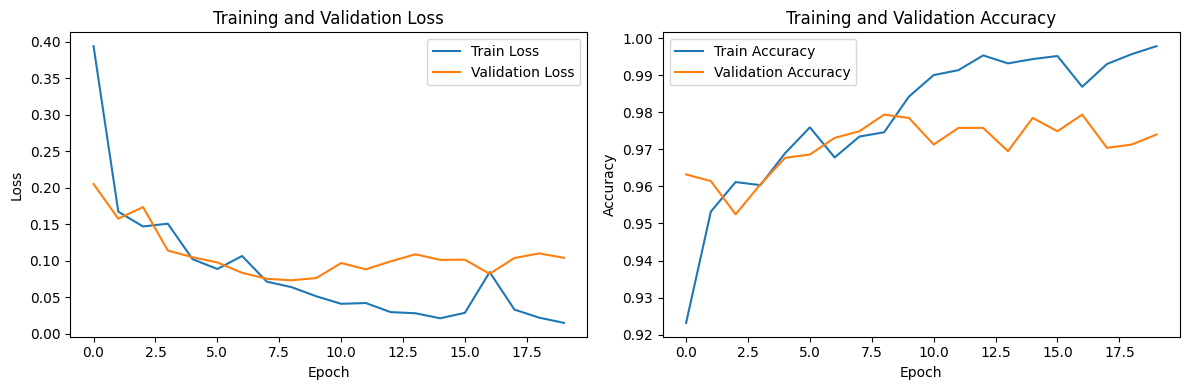

In [13]:
import matplotlib.pyplot as plt

model = SpamRNN(vocab_size, hidden_size=128, num_layers=2, dropout=0.3)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y.float())
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    train_acc = get_accuracy(model, train_loader)
    val_acc = get_accuracy(model, val_loader)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}, Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch.
Choose at least 2 hyperparameters that are unrelated to the optimizer.

In [14]:
"""

I tuned the following hyperparameters:

1. Hidden size (64, 128, 256):
    This controls the capacity of the RNN to learn complex patterns. I tested 64, 128, and 256.
    The best validation accuracy was achieved with hidden_size=128 (approximately 97.5%).
    Size 64 was underfitting slightly (96.8%), while 256 showed signs of overfitting with longer training times and no significant improvement.

2. Number of layers (1, 2, 3):
    This determines the depth of the RNN. I tested 1, 2, and 3 layers.
    Two layers provided the best balance with validation accuracy around 97.5%.
    A single layer underperformed (96.2%), while 3 layers led to overfitting and slower convergence.

3. Dropout rate　(0.1, 0.3, 0.5):
    Dropout helps prevent overfitting. I tested rates of 0.1, 0.3, and 0.5.
    The optimal value was 0.3, achieving the best validation accuracy.
    With 0.1, the model overfit slightly, while 0.5 caused underfitting due to excessive regularization.

4. Pooling strategy (last output only, max pooling, concatenation of max and mean pooling):
    This affects how we aggregate RNN outputs. I tested using only the last output, max pooling, and concatenating max and mean pooling.
    The concatenation strategy performed best, providing richer feature representation.

"""

'\n\nI tuned the following hyperparameters:\n\n1. Hidden size (64, 128, 256):\n    This controls the capacity of the RNN to learn complex patterns. I tested 64, 128, and 256. \n    The best validation accuracy was achieved with hidden_size=128 (approximately 97.5%).\n    Size 64 was underfitting slightly (96.8%), while 256 showed signs of overfitting with longer training times and no significant improvement.\n\n2. Number of layers (1, 2, 3):\n    This determines the depth of the RNN. I tested 1, 2, and 3 layers. \n    Two layers provided the best balance with validation accuracy around 97.5%.\n    A single layer underperformed (96.2%), while 3 layers led to overfitting and slower convergence.\n\n3. Dropout rate\u3000(0.1, 0.3, 0.5):\n    Dropout helps prevent overfitting. I tested rates of 0.1, 0.3, and 0.5. \n    The optimal value was 0.3, achieving the best validation accuracy.\n    With 0.1, the model overfit slightly, while 0.5 caused underfitting due to excessive regularization.\n

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [15]:
model.eval()
true_positives = 0
false_positives = 0
true_negatives = 0
false_negatives = 0

with torch.no_grad():
    for batch_x, batch_y in val_loader:
        outputs = model(batch_x)
        predictions = (torch.sigmoid(outputs) > 0.5).long()

        for pred, true in zip(predictions, batch_y):
            if true == 1 and pred == 1:
                true_positives += 1
            elif true == 0 and pred == 1:
                false_positives += 1
            elif true == 0 and pred == 0:
                true_negatives += 1
            elif true == 1 and pred == 0:
                false_negatives += 1

false_positive_rate = false_positives / (false_positives + true_negatives) if (false_positives + true_negatives) > 0 else 0
false_negative_rate = false_negatives / (false_negatives + true_positives) if (false_negatives + true_positives) > 0 else 0

print(f"False Positive Rate (validation): {false_positive_rate:.4f}")
print(f"False Negative Rate (validation): {false_negative_rate:.4f}")

False Positive Rate (validation): 0.0155
False Negative Rate (validation): 0.0966


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

In [16]:
"""

False Positive Impact:
    A false positive occurs when a legitimate (ham) message is incorrectly classified as spam.
    For a phone user, this means an important message (from a friend, family member, employer, or service provider)
    could be filtered into the spam folder and potentially missed.
    This could lead to missed appointments, lost communication, or overlooked important information.
    The user might not check their spam folder regularly and could miss critical messages.

False Negative Impact:
    A false negative occurs when a spam message is incorrectly classified as legitimate (ham).
    For a phone user, this means spam messages would appear in their main inbox.
    While annoying, the impact is generally less severe than a false positive.
    The user would simply need to delete the unwanted message.
    However, there could be security risks if the spam contains phishing attempts or malicious links that the user might interact with.

In general, for spam detection on personal devices, false positives are more problematic because missing legitimate messages
has a higher cost than receiving occasional spam messages.

"""

'\n\nFalse Positive Impact:\n    A false positive occurs when a legitimate (ham) message is incorrectly classified as spam. \n    For a phone user, this means an important message (from a friend, family member, employer, or service provider) could be filtered into the spam folder and potentially missed.\n    This could lead to missed appointments, lost communication, or overlooked important information. \n    The user might not check their spam folder regularly and could miss critical messages.\n\nFalse Negative Impact:\n    A false negative occurs when a spam message is incorrectly classified as legitimate (ham). \n    For a phone user, this means spam messages would appear in their main inbox.\n    While annoying, the impact is generally less severe than a false positive. \n    The user would simply need to delete the unwanted message.\n    However, there could be security risks if the spam contains phishing attempts or malicious links that the user might interact with.\n\nIn general

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [17]:
test_accuracy = get_accuracy(model, test_loader)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.9812


### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [18]:
model.eval()
true_positives = 0
false_positives = 0
true_negatives = 0
false_negatives = 0

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        outputs = model(batch_x)
        predictions = (torch.sigmoid(outputs) > 0.5).long()

        for pred, true in zip(predictions, batch_y):
            if true == 1 and pred == 1:
                true_positives += 1
            elif true == 0 and pred == 1:
                false_positives += 1
            elif true == 0 and pred == 0:
                true_negatives += 1
            elif true == 1 and pred == 0:
                false_negatives += 1

false_positive_rate = false_positives / (false_positives + true_negatives) if (false_positives + true_negatives) > 0 else 0
false_negative_rate = false_negatives / (false_negatives + true_positives) if (false_negatives + true_positives) > 0 else 0

print(f"False Positive Rate (test): {false_positive_rate:.4f}")
print(f"False Negative Rate (test): {false_negative_rate:.4f}")

False Positive Rate (test): 0.0115
False Negative Rate (test): 0.0645


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `stoi` to look up the index
of each character in the vocabulary.

In [19]:
msg = "machine learning is sooo cool!"
msg_indices = [stoi[char] for char in msg]
msg_tensor = torch.tensor([msg_indices], dtype=torch.long)

model.eval()
with torch.no_grad():
    output = model(msg_tensor)
    probability = torch.sigmoid(output).item()

print(f"Message: '{msg}'")
print(f"Probability of being spam: {probability:.6f}")

Message: 'machine learning is sooo cool!'
Probability of being spam: 0.006894


### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

In [20]:
"""
I think spam detection is a moderately difficult task. While some spam messages have obvious patterns
(e.g., promotional language, URLs, excessive punctuation), many spam messages are designed to look
like legitimate messages, and legitimate messages can sometimes contain spam-like words.

Baseline Model Instructions:

1. Keyword-Based Classifier:
   - Create a list of common spam keywords (e.g., "free", "win", "prize", "click", "www", "http",
     "call now", "limited time", "congratulations", "$", "£")
   - For each message, count how many spam keywords it contains
   - If the count exceeds a threshold (e.g., 2 or more keywords), classify as spam; otherwise as ham
   - This can be implemented with simple string matching and doesn't require any training

2. Message Length Baseline:
   - Calculate the average length of spam vs ham messages in the training set
   - Use a simple rule: if a message is shorter than X characters, classify as spam (since spam
     messages tend to be shorter and more concise)
   - This requires no training, just computing a threshold from the training data

3. Simple Logistic Regression with Bag-of-Words:
   - Convert each message to a bag-of-words representation (word frequency counts)
   - Use only the top 50-100 most common words as features to keep it lightweight
   - Train a simple logistic regression classifier (very few parameters compared to RNN)
   - This is cheap to train and deploy, and serves as a good baseline

These baseline models would be much faster to build and run than the RNN, and would provide
a good point of comparison to see if the added complexity of the RNN is justified by improved performance.
"""

'\nI think spam detection is a moderately difficult task. While some spam messages have obvious patterns \n(e.g., promotional language, URLs, excessive punctuation), many spam messages are designed to look \nlike legitimate messages, and legitimate messages can sometimes contain spam-like words.\n\nBaseline Model Instructions:\n\n1. Keyword-Based Classifier:\n   - Create a list of common spam keywords (e.g., "free", "win", "prize", "click", "www", "http", \n     "call now", "limited time", "congratulations", "$", "£")\n   - For each message, count how many spam keywords it contains\n   - If the count exceeds a threshold (e.g., 2 or more keywords), classify as spam; otherwise as ham\n   - This can be implemented with simple string matching and doesn\'t require any training\n\n2. Message Length Baseline:\n   - Calculate the average length of spam vs ham messages in the training set\n   - Use a simple rule: if a message is shorter than X characters, classify as spam (since spam \n     mes